In [10]:
import pandas as pd

oj = pd.read_csv("../../data/OJ.csv")
oj

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


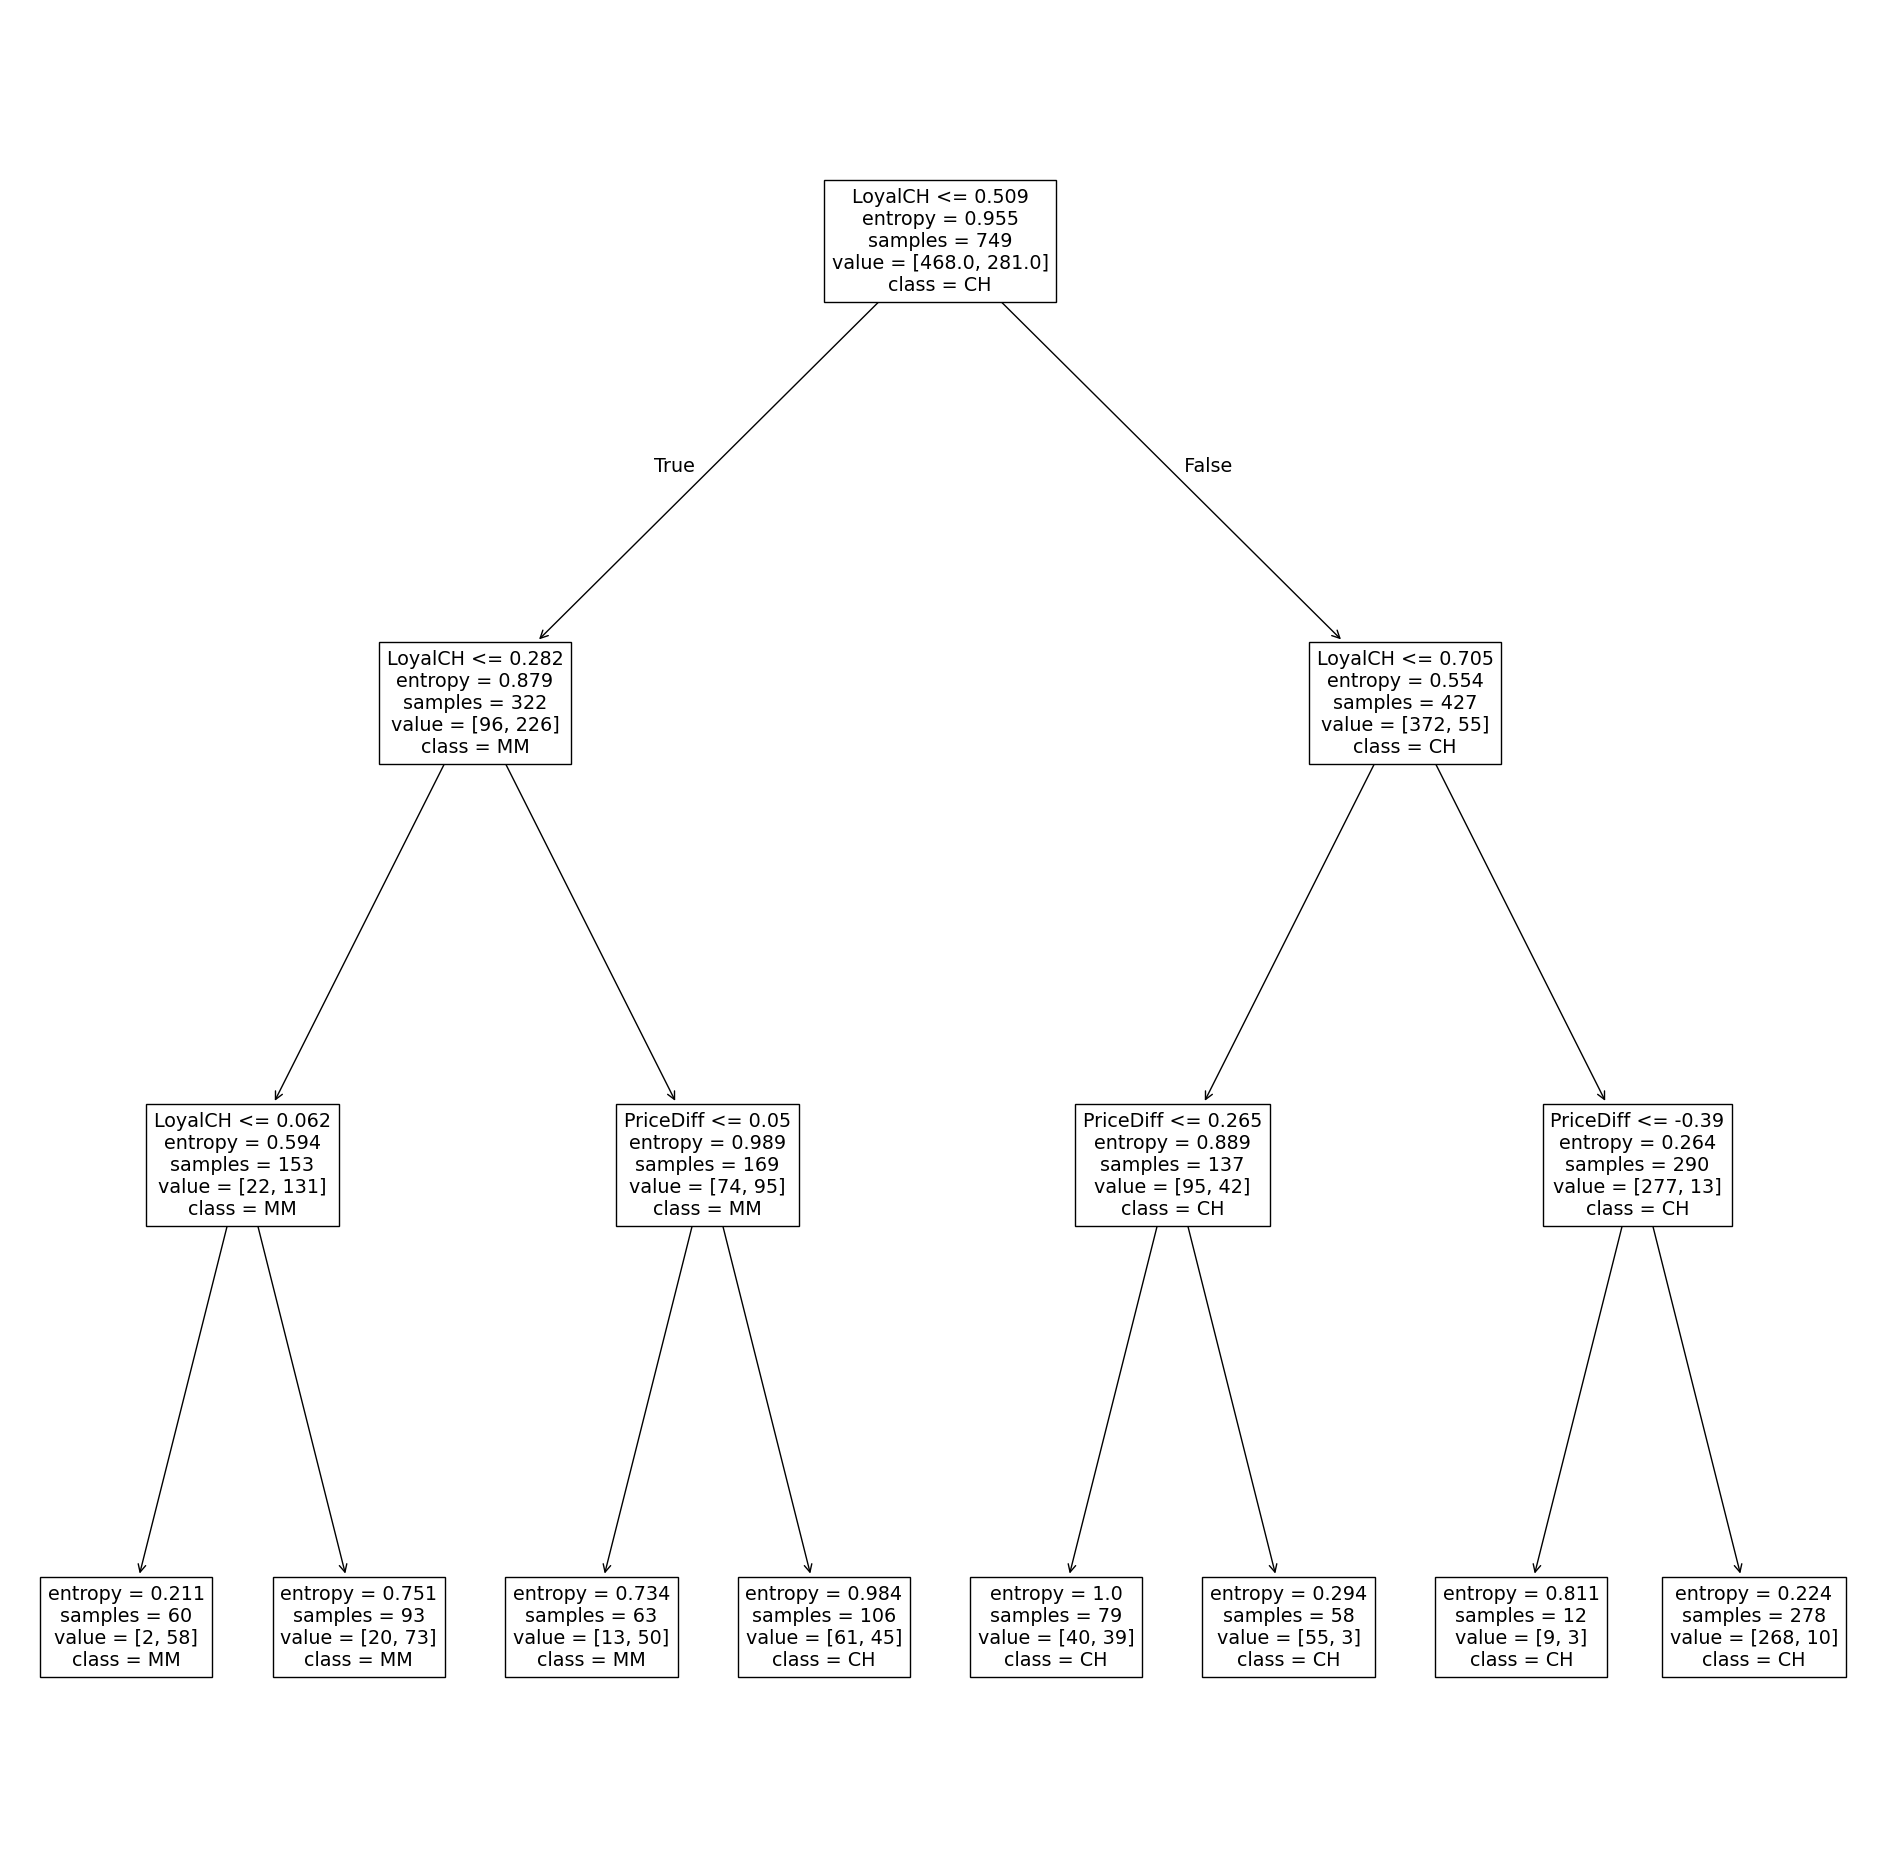

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
import sklearn.model_selection as skm
import matplotlib.pyplot as plt

X = oj[oj.columns.drop("Purchase")]
Y = oj["Purchase"]

X_encoded = pd.get_dummies(X, drop_first=True)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X_encoded,
                                Y,
                                test_size=0.3,
                                random_state=0)


tree = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)

tree.fit(X_train, y_train)
ax = plt.subplots(figsize=(24,24))[1]

feature_names = X_encoded.columns
class_names = tree.classes_

plot_tree(tree,
          feature_names=feature_names,
          class_names=class_names,
          ax=ax);

In [15]:
from sklearn.tree import export_text

print(export_text(tree,
                  feature_names=feature_names,
                  show_weights=True))


|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- weights: [2.00, 58.00] class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- weights: [20.00, 73.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [13.00, 50.00] class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [61.00, 45.00] class: CH
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- weights: [40.00, 39.00] class: CH
|   |   |--- PriceDiff >  0.27
|   |   |   |--- weights: [55.00, 3.00] class: CH
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- weights: [9.00, 3.00] class: CH
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- weights: [268.00, 10.00] class: CH



In [12]:
train_accuracy = tree.score(X_train, y_train)
train_error = 1 - train_accuracy

print("Training error:", train_error)


Training error: 0.18024032042723637


The decision tree for the OJ dataset shows that **LoyalCH** is the most important predictor, appearing at the root and the first few splits. Nodes with higher **LoyalCH** values tend to predict the “CH” class, while lower values push observations toward “MM.” The next most influential variable is **PriceDiff**, which further distinguishes purchases within branches of similar loyalty. Entropy values at the root and some intermediate nodes are relatively high (close to 1), indicating a mix of classes and uncertainty in those splits, while leaf nodes generally have lower entropy, reflecting more homogeneous class assignments. For example, the leftmost branch corresponds to very low **LoyalCH** and small **PriceDiff**, leading to a majority of “MM” purchases, whereas the rightmost branch has higher **LoyalCH** and negative **PriceDiff**, predicting mostly “CH” purchases. Overall, the tree captures that customer loyalty and price differences are the dominant factors in predicting the brand choice in this dataset.

In [18]:
from ISLP import confusion_table

y_pred = tree.predict(X_test)
confusion_table(y_test, y_pred)


Truth,CH,MM
Predicted,,
CH,169,16
MM,42,94


In [21]:
import numpy as np

1 - np.mean(y_pred == y_test)

np.float64(0.18068535825545173)

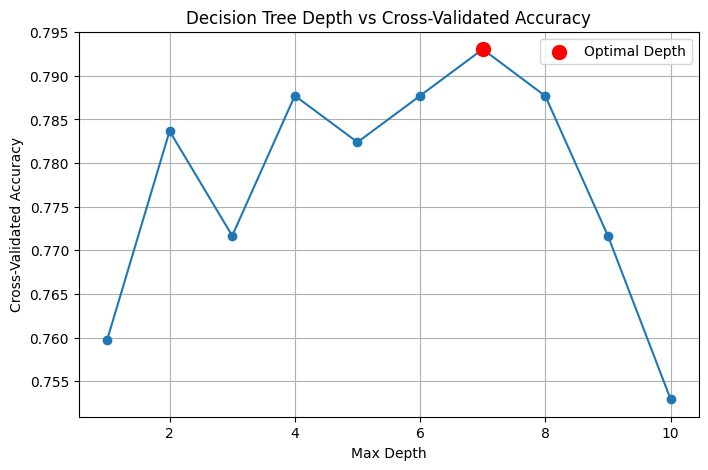

In [29]:
from sklearn.model_selection import cross_val_score

max_depths = range(1, 11)
cv_scores = []

for depth in max_depths:
    tree = DTC(criterion='entropy',
                                  max_depth=depth,
                                  random_state=0)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_depth = max_depths[np.argmax(cv_scores)]

plt.figure(figsize=(8,5))
plt.plot(max_depths, cv_scores, marker='o')

plt.scatter(optimal_depth, cv_scores[optimal_depth - 1], color='r', s=100, zorder=5, label='Optimal Depth')

plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Decision Tree Depth vs Cross-Validated Accuracy")
plt.grid(True)
plt.legend()
plt.show()



In [43]:
tree = DTC(criterion='entropy',
            max_depth=optimal_depth,
            random_state=0)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)
y_train_hat = tree.predict(X_train)

print("Test error:" , np.mean(y_test != y_hat))
print("Training error:" , np.mean(y_train != y_train_hat))

Test error: 0.21495327102803738
Training error: 0.1041388518024032


In [37]:

ccp_path = tree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(
    tree,
    {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring='accuracy'
)
G = grid.fit(X_train, y_train)

best_tree = G.best_estimator_

best_tree.get_depth()

3

In [44]:
best_tree.fit(X_train, y_train)

y_hat = best_tree.predict(X_test)
y_train_hat = best_tree.predict(X_train)

print("Test error:" , np.mean(y_test != y_hat))
print("Training error:" , np.mean(y_train != y_train_hat))

Test error: 0.1806853582554517
Training error: 0.1802403204272363


When we initially trained the decision tree using the optimal depth of 7 obtained from cross-validation, the tree was relatively complex and achieved a test error of approximately 0.215. However, after applying cost-complexity pruning, the tree was simplified to a depth of 3. This pruning removed unnecessary splits that likely captured noise in the training data, resulting in a more generalizable model. Consequently, the test error decreased to approximately 0.181, demonstrating that a simpler tree can improve predictive performance on unseen data by reducing overfitting. This illustrates the trade-off between tree complexity and generalization: deeper trees may fit the training data better but can overfit, while pruned, shallower trees often achieve lower error on test data.